In [1]:
from known_boundary.GP import optimise,optimise_warp
from known_boundary.utlis import Trans_function, get_initial_points,transform
from known_boundary.acquisition_function import EI_acquisition_opt,MES_acquisition_opt,Warped_TEI2_acquisition_opt,LCB_acquisition_opt,ERM_acquisition_opt
from obj_functions.obj_function import XGBoost

/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import torch
import botorch
from botorch.utils.transforms import unnormalize,normalize

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [5]:
standard_bounds =np.array([0.,1.]*6).reshape(-1,2) 
n_init = 18
iter_num = 30
N = 20

# EI

In [13]:
BO_EI = []

for exp in range(N):
    
    print(exp)

    seed = exp
    
    fun = XGBoost('breast',seed=exp)
    dim = fun.dim
    bounds = fun.bounds
    
    fstar = 100
    fun = Trans_function(fun,fstar,min=False)
    

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    np.random.seed(1234)
    
    best_record = [Y_BO.min().item()]
    
    init_best = Y_BO.min().item()
    improvement = []

    for i in range(iter_num):
        
            #print(i)
        
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            minimal = train_Y.min().item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            # print('lengthscale is: ',np.sqrt(res[0])) 
            # print('variance is: ',res[1])
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = torch.tensor( [fun(X_next) ]).reshape(1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
            improvement.append(init_best - Y_BO.min().item())
            
    best_record = fstar-(np.array(best_record))
    BO_EI.append(improvement)
    

0
6.851851851851848
6.851851851851848
6.851851851851848
6.851851851851848
6.481481481481495
6.481481481481495
6.481481481481495
6.481481481481495
6.481481481481495
6.481481481481495
6.481481481481495
6.481481481481495
6.296296296296305
6.296296296296305
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
1
5.740740740740748
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
4.8148148148148096
4.8148148148148096
4.8148148148148096
4.8148148148148096
4.8148148148148096
4.8148148148148096
4.8148148148148096
4.814814814814809

In [8]:
BO_EI

[array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100.])]

#

# MES

In [20]:
BO_MES = []

for exp in range(N):

    seed = exp
    
    print(exp)
    
    fun = XGBoost('breast',seed=exp)
    dim = fun.dim
    bounds = fun.bounds
    
    fstar = 100
    fun = Trans_function(fun,fstar,min=False)


    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)
    
    fstar_mes = 0. 

    best_record = [Y_BO.min().item()]
    np.random.seed(1234)

    for i in range(iter_num):
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            
            fstar_standard = (fstar_mes - Y_BO.mean()) / Y_BO.std()
            fstar_standard = fstar_standard.item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = MES_acquisition_opt(m,standard_bounds,fstar_standard)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = torch.tensor( [fun(X_next.reshape(6,)) ]).reshape(1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = fstar-(np.array(best_record))
    BO_MES.append(best_record)




0
6.851851851851848
6.851851851851848
6.851851851851848
6.851851851851848
6.851851851851848
6.851851851851848
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
1
5.740740740740748
5.740740740740748
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.370370370370381
4.444444444444457
4.444444444444457
4.444444444444457
4.444444444444457
4.444444444444457
4.444444444444457
4.4444

In [37]:
fun = XGBoost(seed=exp)
dim = fun.dim
bounds = fun.bounds

fstar = 100
fun = Trans_function(fun,fstar,min=False)


X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
Y_BO = torch.tensor(
    [fun(x.numpy()) for x in X_BO], dtype=dtype, device=device
).reshape(-1,1)

# Y_BO = torch.tensor(
#     [fun(x.numpy()) for x in X_BO], dtype=dtype, device=device
# ).reshape(-1,1)

In [38]:
Y_BO

tensor([[14.7699],
        [ 2.2553],
        [ 2.3287],
        [14.7318],
        [15.2814],
        [14.7944],
        [ 2.0322],
        [14.9222],
        [15.0012],
        [ 2.7776],
        [ 1.9043],
        [14.8189],
        [14.8760],
        [ 1.8472],
        [15.0692],
        [14.5523],
        [ 2.8782],
        [14.8053]], dtype=torch.float64)

In [30]:
fun = XGBoost(seed=exp)
dim = fun.dim
bounds = fun.bounds

fstar = 100
fun = Trans_function(fun,fstar,min=False)


X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
Y_BO = torch.tensor(
    [fun(x) for x in X_BO], dtype=dtype, device=device
).reshape(-1,1)

In [31]:
Y_BO

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], dtype=torch.float64)

In [15]:
Y_BO

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], dtype=torch.float64)

In [9]:
dim

6

In [10]:
X_next.reshape()

tensor([[6.9881, 7.8309, 7.7919, 6.5102, 0.5698, 0.8017]], dtype=torch.float64)

In [11]:
fun(X_next)

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [13]:
X_next[1]

IndexError: index 1 is out of bounds for dimension 0 with size 1

# ERM

In [ ]:
BO_ERM = []

for exp in range(N):

  print(exp)  
  seed = exp
  
  fun = XGBoost(seed=exp)
  dim = fun.dim
  bounds = fun.bounds
  
  fstar = 100
  fun = Trans_function(fun,fstar,min=False)

  fstar0 = 0.
  Trans = False

  X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
  Y_BO = torch.tensor(
            [fun(x) for x in X_BO], dtype=dtype, device=device
        ).reshape(-1,1)

  best_record = [Y_BO.min().item()]

  for iter in range(iter_num):

    #print(iter)
    train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
    train_X = normalize(X_BO, bounds)
    
    train_Y = train_Y.numpy()
    train_X = train_X.numpy()
    

    fstar_standard = (fstar0 - Y_BO.mean()) / Y_BO.std()
    fstar_standard = fstar_standard.item()
    
    if not Trans:
      minimal = np.min(train_X)
      res = optimise(train_X,train_Y)
      kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
      m = GPy.models.GPRegression(train_X, train_Y,kernel)
      m.Gaussian_noise.variance.fix(10**(-5))

      standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
      
      beta = np.sqrt(np.log(train_X.shape[0]))
      _,lcb = LCB_acquisition_opt(m,standard_bounds,beta)
      if lcb < fstar_standard:
        Trans = True
      
    else:
      
      #print('transfromed GP')
              
      train_Y_transform = transform(y=train_Y,fstar=fstar_standard)
      mean_temp = np.mean(train_Y_transform)
      
      res = optimise(train_X,(train_Y_transform-mean_temp))
      kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
      m = GPy.models.GPRegression(train_X, train_Y_transform-mean_temp,kernel)
      m.Gaussian_noise.variance.fix(10**(-5))
      standard_next_X,erm_value = ERM_acquisition_opt(m,bounds=standard_bounds,fstar=fstar_standard,mean_temp=mean_temp)
    
    
    X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)     
    Y_next = fun(X_next).reshape(-1,1)

    # Append data
    X_BO = torch.cat((X_BO, X_next), dim=0)
    Y_BO = torch.cat((Y_BO, Y_next), dim=0)

    best_value = float(Y_BO.min())
    best_record.append(best_value)


  best_record = fstar-(np.array(best_record))
  BO_ERM.append(best_record)
  
np.savetxt('exp_res/XGBoost_BO_ERM', BO_ERM, delimiter=',')

# log GP

In [11]:
Warped_BO_TEI2 = []

for exp in range(N):

    seed = exp
    
    print(exp)
    
    fun = XGBoost('breast',seed=exp)
    dim = fun.dim
    bounds = fun.bounds
    
    fstar = 100
    fun = Trans_function(fun,fstar,min=False)
    

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    np.random.seed(1234)

    best_record = [Y_BO.min().item()]
    
    init_best = Y_BO.min().item()
    improvement = []

    for i in range(iter_num):
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise_warp(train_X, train_Y)
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))
            
            standard_next_X = Warped_TEI2_acquisition_opt(model=m,bounds=standard_bounds,f_best=best_record[-1],c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
            improvement.append(init_best - Y_BO.min().item())
            
    best_record = fstar-(np.array(best_record))     
    #Warped_BO_TEI2.append(best_record)
    Warped_BO_TEI2.append(np.array(improvement))
    
    #np.savetxt('exp_res/Bank_logGP+logTEI', Warped_BO_TEI2, delimiter=',')

0
6.851851851851848
6.851851851851848
6.851851851851848
6.851851851851848
6.851851851851848
6.851851851851848
6.296296296296305
6.296296296296305
6.296296296296305
6.296296296296305
6.296296296296305
6.296296296296305
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
6.111111111111114
5.925925925925938
5.925925925925938
5.925925925925938
5.925925925925938
5.925925925925938
5.925925925925938
5.925925925925938
5.925925925925938
5.925925925925938
5.925925925925938
5.925925925925938
5.925925925925938
1
5.740740740740748
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.555555555555557
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.8148148148148096
4.8148148148148096
4.8148148148148096
4.8148148148148096
4.8148148148148096
4.8148148148148096
2
7.222222222222214
7.222222222222214
7.222222222222214
7.222222222222214
7.222222222222214
7.222222222222214
7.22222222

In [8]:
seed = 0

fun = XGBoost('bank',seed=seed)
dim = fun.dim
bounds = fun.bounds

fstar = 99
fun = Trans_function(fun,fstar,min=False)


X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
Y_BO = torch.tensor(
    [fun(x) for x in X_BO], dtype=dtype, device=device
).reshape(-1,1)

Y_BO

tensor([[14.3975],
        [10.5085],
        [ 8.4842],
        [15.6156],
        [15.1295],
        [ 8.9700],
        [ 8.8884],
        [15.5337],
        [15.0479],
        [ 6.0501],
        [ 9.2120],
        [15.6966],
        [ 9.6939],
        [ 6.2967],
        [ 8.1554],
        [14.7223],
        [ 6.4547],
        [ 8.2403]], dtype=torch.float64)

# Plot

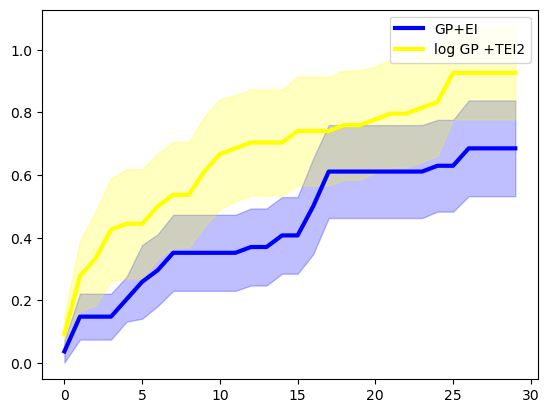

In [14]:
N = 10
total_record = np.array(BO_EI)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

# total_record = np.array(BO_MES)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,label='GP+MES',color='#c22f2f')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = np.array(Warped_BO_TEI2)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI2',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

# total_record = np.array(BO_ERM)-fstar
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,label='ERM',color='black')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

# total_record = np.array(BO_LCB)-fstar
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,label='LCB',color='green')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='green')

plt.legend()